# LGT Unit 3 day 13 exercises

In [16]:
import gpt as g
import numpy as np
import matplotlib.pyplot as plt

In [17]:
grid = g.grid([8,8,8,16], g.double) #initialize a double precision grid

## 1. Wilson Dirac operator spectra

In this section we will examine the spectra of a non-GW fermion operator, the Wilson Dirac operator, which explicitly breaks chiral symmetry. We will look at the eigenvalues of this operator in the complex plane, and compare these eigenvalues to the Ginsparg-Wilson circle.

In [18]:
'''
U_f is set to unit links everywhere, this allows us to simulate the free theory. Use this U_f gauge field for the exercises
first, then if you want you can use the quenched configuration generation cell to generate a configuration to use in the interacting case. 
'''
U_f = g.qcd.gauge.unit(grid)
start = g.vspincolor(grid)

In [32]:
'''
Only run this cell to generate a configuration to use in the optional exercises. 
'''

# Do not modify anything in this cell.
Ls = 8
Lt = 16
beta = 5.5
L = [Ls,Ls,Ls,Lt]
grid = g.grid(L, g.single)
grid_eo = g.grid(L, g.single, g.redblack)

rng = g.random("fkbrfr", "vectorized_ranlux24_24_64") #change this?
U = g.qcd.gauge.unit(grid)
Nd = len(U)

# red/black mask
mask_rb = g.complex(grid_eo)
mask_rb[:] = 1
# full mask
mask = g.complex(grid)

# simple plaquette action
def staple(U, mu):
    st = g.lattice(U[0])
    st[:] = 0
    Nd = len(U)
    for nu in range(Nd):
        if mu != nu:
            st += g.qcd.gauge.staple(U, mu, nu) / U[0].otype.Nc
    return st

g.default.push_verbose("su2_heat_bath", False)
markov = g.algorithms.markov.su2_heat_bath(rng)
U = g.qcd.gauge.unit(grid)
plaquette_heatbath = []
for it in range(101):
    plaq = g.qcd.gauge.plaquette(U)
    plaquette_heatbath.append(plaq)
    if it % 100 == 0 and it != 0:
        g.message(f"SU(2)-subgroup heatbath {it} has P = {plaq}")
        Uc = g.copy(U)
    for cb in [g.even, g.odd]:
        mask[:] = 0
        mask_rb.checkerboard(cb)
        g.set_checkerboard(mask, mask_rb)
        
        for mu in range(Nd):
                    st = g.eval(beta * staple(U, mu))
                    markov(U[mu], st, mask)

GPT :   17833.512283 s : Initializing gpt.random(fkbrfr,vectorized_ranlux24_24_64) took 2.98023e-05 s
GPT :   17869.898001 s : SU(2)-subgroup heatbath 100 has P = 0.4952442381117079


In [19]:
#do not modify anyhting in this cell
'''
This function defines the Wilson Dirac operator, then uses the Arnoldi algorithm to calculate the eigenvalues and eigenvectors.
it only returns the eigenvalues, because that is all we will be using in these exercises. 
'''
def compute_evs_Wilson(U,m):

    w = g.qcd.fermion.wilson_clover(U, mass=m, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0, isAnisotropic=False,
                                   boundary_phases=[1,1,1,-1])

    start = g.vspincolor(w.F_grid)
    g.default.set_verbose("arnoldi", False)
    a = g.algorithms.eigen.arnoldi(Nmin=700, Nmax=1400, Nstep=100, Nstop=500,resid=1e-6,implicit_restart=True)

    evec, evals = a(w,start)
    return evals

In [23]:
#do not modify anything in this cell
'''
This line runs the above code - we input the gauge field we want to use, U_f for the free case, and the bare mass of the Wilson Dirac operator.
We are interested in zero bare quark mass, so we put in a small number to get as close as we can. 

Note: This cell takes about a minute to run. 
'''

ev_Wilson_free = compute_evs_Wilson(U_f,-0.01)
#ev_Wilson_int = compute_evs_Wilson(U_q, -0.01)

### Exercise 1.1: Wilson spectra plot

Plot the eigenvalues we just generated in the complex plane, along with the GW circle. Comment on the structure of the eigenvalues in relation to the GW circle. 

recall the GW circle has the form
$$
    \left(x - \frac{1}{a}\right)^2 + y^2 = \frac{1}{a^2}
$$

where we will set the lattice spacing $a = 1$

In [38]:
#Modify this cell
'''
Plot the eigenvalues and the GW circle (The GW circle is simply a circle of radius 1 centered at (0,1). 
''';

### Exercise 1.2 (optional): Interacting Wilson spectra

Generate a quenched config using the cell at the top of the notebook, and calculate the eigenvectors and eigenvalues in the interacting case. Plot the eigenvalues and GW circle on the same plot. 

In [39]:
#modify this cell (if you want)
'''
Plot the eigenvalues in the interacting case (this is optional)
''';

### Overlap fermions

In this part we will introduce the first example of a Ginsparg-Wilson fermion formulation in overlap fermions, which is effectively a chiral projection of a non-GW fermion operator.

For this part of the exercise, we are going to calculate the eigenvalues and eigenvectors of the overlap operator:
$$
D_{\text{ov}} = \frac{1}{a}(1 + \gamma_5\text{sign}[H]), \quad H = \gamma_5A
$$
for some general Hermitian kernel operator $H$. 

We will use the Wilson Dirac operator as $A$, thus $H = \gamma_5D_w(m = -M_5)$, where we usually take $M_5 = -1.8$. This 'mass' parameter does not correspond to the mass of the fermion this operator describes, we are still working with massless fermions for any $M_5$.

### Exercise 2.1: (Analytic)

Show the general form of the overlap operator is a solution to the Ginsparg-Wilson equation,
$$
D\gamma_5 + \gamma_5D = aD\gamma_5D
$$

The overlap operator is gauge invariant and chirally symmetric, and its free of doublers because the kernel we are using is free of doublers, the Wilson Dirac operator. Any doubler free lattice Dirac operator can be used as the kernel, and the overlap operator will show these same properties. In this sense we can think of the overlap operator as a projection of a non-chiral doubler free lattice operator onto a chirally symmetric Dirac operator. 

Now we want to look at the spectrum of the overlap operator with the Wilson Dirac operator as its kernel. The tricky part is the evaluation of the Sign function, which acts by replacing all of the operator's eigenvalues by their sign. As a first step, we rewrite the sign function as 
$$
\text{Sign[H]} = \frac{H}{|H|} = \frac{H}{\sqrt{H^2}}
$$
The main issue is how to apply the $\sqrt{H^2}$ term to a given vector. We are first interested in looking at the spectrum of $H^2$. We take the common choice of $M_5 = -1.8$.

In [25]:
# Do not modify anything in this cell
'''
This code defines the Wilson operator with m = -M_5, and then defines the numerical implementation of sign(H). We also calculate the eigenvalues 
and eigenvectors of H^2 to demonstrate a key step in the implementation of fermion operators with very small eigenvalues. 
'''

w = g.qcd.fermion.wilson_clover(U_f, mass=-1.8, csw_r=0.0, csw_t=0.0, nu=1.0, xi_0=1.0,
                                isAnisotropic=False,boundary_phases=[1,1,1,-1])

#initialize random quark fields for the operator to act on
start = g.vspincolor(w.F_grid)
rng = g.random("evecs")
rng.normal(start)

#function that defines H^2
def H2(dst,src):
    dst @= g.gamma[5] * w * g.gamma[5] * w * src

#We use the arnoldi algorithm on the H^2 operator.
g.default.set_verbose("arnoldi",False)
a = g.algorithms.eigen.arnoldi(Nmin=700, Nmax=1400, Nstep=100, Nstop=500, resid=1e-6, implicit_restart=True)

evecH2, evalsH2 = a(H2,start)

GPT :   16417.609564 s : Initializing gpt.random(evecs,vectorized_ranlux24_389_64) took 0.00519133 s


Text(0, 0.5, 'eigenvalue of H^2')

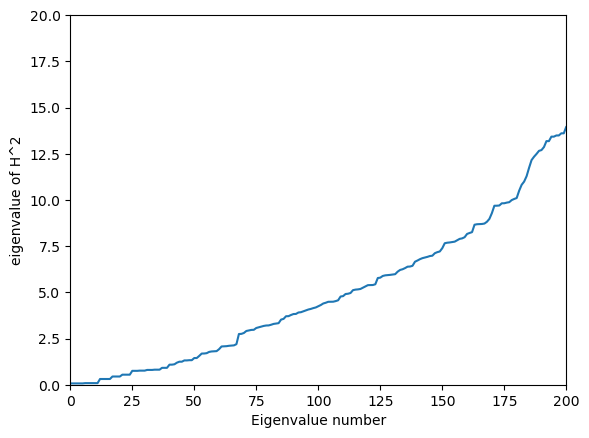

In [34]:
fig2,ax2 = plt.subplots()

ax2.plot(list(range(len(evalsH2))),sorted([e.real for e in evalsH2]))
ax2.set_xlim(0,200)
ax2.set_ylim(0,20)
ax2.set_xlabel("Eigenvalue number")
ax2.set_ylabel("eigenvalue of H^2")

We clearly have some small eigenvalues. A common thing to do when evaluating the overlap operator is to define a deflated operator
$$
H^2_{\text{def}} = H^2 - \sum_n \lambda_n |n\rangle\langle n|
$$
with eigenvalues $\lambda_n$ and eigenvectors $|n\rangle$, and the sum running over the smallest eigenvalues up to a given threshold. 

We combine this small eigenmode subtraction with a polynomial approximation using Chebyshev polynomials. Chebyshev polynomials are defined in the interval $[-1,1]$, so we map the domain of eigenvalues into the domain of the Chebyshev polynomials. Then we expand the function in a truncated series,
$$
 r(x) \approx \sum_{n=0}^{N-1}c_nT_n(x)
$$
in our case, for the inverse square root function, for $\lambda \in [\alpha^2,\beta^2]$
$$
r(x) = \frac{1}{\sqrt{\lambda(x)}} = \left(\frac{1}{2}(\beta^2 + \alpha^2) + \frac{x}{2}(\beta^2 - \alpha^2)\right)^{-1/2}
$$
The coefficients are defined by
$$
c_n = \frac{\pi}{N}\sum_{k=1}^Nr(x_k)T_n(x_k),\quad x_k = \cos\left(\left(k-\frac{1}{2}\right)\frac{\pi}{N}\right)
$$
and the approximation of the sign function comes from multiplication by $H$
$$
\text{sign}[H] = \frac{H}{\sqrt{H^2}} = H\sum_{n=0}^{N-1}c_nT_n(X) + \mathcal{O}(\text{exp}(-2N|\alpha/\beta|))
$$
where 
$$
 X = \frac{2H^2 - (\beta^2 + \alpha^2)}{\beta^2 - \alpha^2}
$$

All of this is conviniently implemented in GPT, and we will use that here.

In [36]:
#do not modify this cell

#with this, c(x) will approximate the function (x)^(-1/2) 
c = g.algorithms.polynomial.chebyshev(low=0.5,high=40,order=30,func=lambda x: x**-0.5)

#sorts the eigenvalues so we can subtract the smallest ones
idx = evalsH2.real.argsort()

#this function is our approximate inverse square root function in the overlap operator
def Hm0p5(dst,src):
    deflated_src = g.copy(src)
    dst[:] = 0
    for i in range(20):
        v = g.inner_product(evecH2[idx[i]],deflated_src)
        dst += evalsH2[idx[i]]**-0.5 * evecH2[idx[i]] * v
        deflated_src -= evecH2[idx[i]] * v
    dst += c(H2) * deflated_src #the return is the chebyshev approximation acting on the deflated field

'''
The form of these functions, F(dst,src) effectively acts the function on the 'src' argument, and returns
it to the "dst" argument. So Hm0p5(dst,src) acts the sign function on src, and puts it in dst. src and dst will be spincolor fields
''';

### Exercise 2.2: definition of the overlap operator

Define the overlap operator in the cell below using the following form in terms of the Wilson Dirac operator $A$.

$$
D_{\text{ov}} = \frac{1}{a}\left(1 + \gamma_5H(H^2)^{-1/2} \right), \quad H = \gamma_5A
$$

$$
D_{\text{ov}} = \frac{1}{a}\left(1 + A(\gamma_5A\gamma_5A)^{-1/2} \right)
$$

The Hm0p5 function above approximates the quantity in the inverse square root, so apply that function first, and complete the expression in the function below. 

In [29]:
#modify this cell
'''
Here you will define the overlap operator, using this Hm0p5 function defined above. Note 'A' in the above expression is the Wilson Dirac operator
which we defined as the variable 'w'. src and dst are fermion fields, defined as spincolor vectors on every site. Note that the 'w' variable MUST act
on one of these vectors when writing the Dirac operator as a function. 
'''

def Overlap(dst,src):
    Hm0p5(dst, src)
    dst @= w * dst + src

In [30]:
#do not modify anything in this cell
'''
This code calculates the eigenvectors and eigenvalues of the overlap operator we just defined using the Arnoldi algorithm.
'''

g.default.set_verbose("arnoldi", False)
a = g.algorithms.eigen.arnoldi(Nmin=300, Nmax=1400, Nstep=100, Nstop=200, resid=1e-6, implicit_restart=True)

evecOv, evalsOv = a(Overlap, start)

### Exercise 2.3

Plot the eigenvalues and the GW cicle in the complex plane again. Note the difference between this graph and what you plotted for the Wilson Dirac operator. 

In [40]:
#Modify this cell
'''
Plot the GW circle and the overlap operator eigenvalues in the complex plane
''';


### Exercise 2.4 (optional)

Do the same analysis but use the quenched configuration as the gauge background. 

In [41]:
#Modify this cell (if you want)
'''
Do the same as exercise 2.3 but in the interacting case. 
''';